In [1]:
# # Cài đặt các gói cần thiết
# !pip install pytorch-lightning
# !pip install torchmetrics
# !pip install transformers
# !pip install datasets
# !pip install gdown


In [19]:
import os
import zipfile
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import gdown
import re
import pandas as pd
import numpy as np
from datasets import Dataset
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
from urllib.request import urlretrieve
from tqdm import tqdm
from datasets import load_dataset
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding)
from datasets import Dataset
from pytorch_lightning import Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [20]:
def download_and_extract_to_working(file_url):
    file_id = re.findall(r'id=([^&]+)', file_url)
    if not file_id:
        file_id = re.findall(r'/d/([^/]+)', file_url)
    
    if not file_id:
        raise ValueError("Could not extract file ID from the provided URL")
    
    file_id = file_id[0]
    
    print(f"Downloading file with ID: {file_id}")
    
    output_zip = "/kaggle/working/output.zip"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)
    
    print(f"Extracting ZIP file to /kaggle/working...")
    csv_paths = []
    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        csv_files = [f for f in file_list if f.endswith('.csv')]
        
        print(f"Found {len(csv_files)} CSV files: {csv_files}")
        
        for file in csv_files:
            zip_ref.extract(file, "/kaggle/working")
            csv_paths.append(f"/kaggle/working/{file}")
    
    print("Extracted files:")
    for path in csv_paths:
        print(f"  - {path} (exists: {os.path.exists(path)})")
    
    return csv_paths

url = "https://drive.google.com/file/d/1e_dG-rpd5ZesOgG9QY8bCmaeczG64ie4/view?usp=sharing"
csv_paths = download_and_extract_to_working(url)

for path in csv_paths:
    print(f"\nReading {path}...")
    df = pd.read_csv(path)
    print(f"Shape: {df.shape}")
    print("First few rows:")
    display(df.head())

Downloading...
From: https://drive.google.com/uc?id=1e_dG-rpd5ZesOgG9QY8bCmaeczG64ie4
To: /kaggle/working/output.zip
100%|██████████| 769k/769k [00:00<00:00, 1.98MB/s]

Extracting ZIP file to /kaggle/working...
Found 3 CSV files: ['val.csv', 'test.csv', 'train.csv']
Extracted files:
  - /kaggle/working/val.csv (exists: True)
  - /kaggle/working/test.csv (exists: True)
  - /kaggle/working/train.csv (exists: True)

Reading /kaggle/working/val.csv...
Shape: (6149, 3)
First few rows:


,id,text,class
0,10000TOZ,Em thực sự ngưỡng mộ sự tâm huyết của thầy/cô ...,2
1,10001CZJ,Thầy/cô đã truyền cho em niềm đam mê học tập v...,2
2,10002MPV,Sự kiên nhẫn của thầy/cô đã giúp em vượt qua m...,2
3,10003MOK,Em biết ơn thầy/cô đã giúp em khám phá được nă...,2
4,10004GXY,Chân thành cảm ơn thầy/cô vì tất cả những gì t...,2



Reading /kaggle/working/test.csv...
Shape: (5900, 3)
First few rows:


,id,text,class
0,10000GCG,Em cảm thấy mình đã trưởng thành hơn rất nhiều...,2
1,10001GQV,Mỗi buổi học đều đem lại cho em niềm vui và sự...,2
2,10002YNC,Em rất biết ơn sự hỗ trợ của thầy cô trong suố...,2
3,10003POQ,Thầy cô đã truyền cảm hứng cho em theo đuổi ướ...,2
4,10004SPS,Em rất hạnh phúc khi được học hỏi những kiến t...,2



Reading /kaggle/working/train.csv...
Shape: (33703, 3)
First few rows:


,id,text,class
0,10000OTP,Khóa học này là một trò hề,1
1,10001PMB,Giảng viên giảng bài như đọc sách,1
2,10002WLF,Tôi đã bỏ ra cả đống tiền cho khóa học này mà ...,1
3,10003UCO,Thật sự tôi không thể tin nổi vào trình độ giả...,1
4,10004WFV,Học phí đắt đỏ nhưng chất lượng giảng dạy thì ...,1


In [4]:
class HCMUTEConsultant(pl.LightningDataModule):
    def __init__(self, tokenizer, config: Dict[str, Any]):
        super().__init__()
        self.tokenizer = tokenizer
        self.batch_size = config['batch_size']
        self.worker_count = config['num_workers']
        self.gpu_enabled = config['on_gpu']
        self.collator = DataCollatorWithPadding(tokenizer=tokenizer)
        self.splits = None
        self.mapping = {"negative": 0, "neutral": 1, "positive": 2}
        self.reverse_label_map = {v: k for k, v in self.mapping.items()}
        self.data_dir = "/kaggle/working"
        
    def setup(self, stage=None):
        train_data = pd.read_csv(f"{self.data_dir}/train.csv")
        val_data = pd.read_csv(f"{self.data_dir}/val.csv")
        
        try:
            test_data = pd.read_csv(f"{self.data_dir}/test.csv")
            if 'class' not in test_data.columns:
                test_data['class'] = 1 
        except Exception as e:
            print(f"Lỗi khi đọc tập test: {e}")
            test_data = pd.DataFrame(columns=['id', 'text', 'class'])
        
        print(f"Đã tải dữ liệu từ {self.data_dir}")
        print(f"Tập huấn luyện: {len(train_data)}, Tập phát triển: {len(val_data)}, Tập kiểm thử: {len(test_data)}")
        print("Cấu trúc mẫu:", train_data.iloc[0].to_dict())
        
        train_data['text'] = train_data['text'].astype(str)
        val_data['text'] = val_data['text'].astype(str)
        test_data['text'] = test_data['text'].astype(str)
                
        if self.splits is None:
            self.splits = {}
            
            raw_splits = {
                'train': Dataset.from_pandas(train_data),
                'val': Dataset.from_pandas(val_data),
                'test': Dataset.from_pandas(test_data)
            }
            
            for split_name, split_data in raw_splits.items():
                print(f"Đang xử lý phần: {split_name}")
                
                try:
                    def process_text(examples):
                        return self.tokenizer(
                            examples['text'],
                            padding='max_length',  
                            truncation=True,
                            max_length=256,
                            return_tensors=None 
                        )
                    
                    processed_data = split_data.map(
                        process_text,
                        batched=True,
                        remove_columns=['id', 'text'], 
                        desc=f"Tokenize {split_name}"
                    )
                    
                    if 'class' in processed_data.column_names:
                        processed_data = processed_data.rename_column('class', 'labels')
                    
                    processed_data = processed_data.with_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
                    
                    self.splits[split_name] = processed_data
                    
                    print(f"Hoàn tất {split_name}, các trường: {processed_data.column_names}")
                    
                except Exception as e:
                    print(f"Lỗi xử lý phần {split_name}: {str(e)}")
                    raise e
    
    def train_dataloader(self):
        if self.splits is None:
            self.setup()
            
        if 'train' not in self.splits or self.splits['train'] is None:
            raise ValueError("Không tìm thấy dữ liệu huấn luyện")
            
        return DataLoader(
            self.splits['train'],
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.worker_count,
            pin_memory=self.gpu_enabled,
            collate_fn=self.collator
        )
    
    def val_dataloader(self):
        if self.splits is None:
            self.setup()
            
        if 'val' not in self.splits or self.splits['val'] is None:
            raise ValueError("Không tìm thấy dữ liệu phát triển")
            
        return DataLoader(
            self.splits['val'],
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.worker_count,
            pin_memory=self.gpu_enabled,
            collate_fn=self.collator
        )
    
    def test_dataloader(self):
        if self.splits is None:
            self.setup()
            
        if 'test' not in self.splits or self.splits['test'] is None:
            raise ValueError("Không tìm thấy dữ liệu kiểm thử")
            
        return DataLoader(
            self.splits['test'],
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=self.worker_count,
            pin_memory=self.gpu_enabled,
            collate_fn=self.collator
        )

In [5]:
class SentimentClassifier(pl.LightningModule):
    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
        self.lr = lr
        self.weight_decay = weight_decay
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3) 
        self.val_f1 = torchmetrics.F1Score(task="multiclass", num_classes=3)   
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=3)
        self.test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=3)
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss, logits = outputs.loss, outputs.logits
        sentiments = batch['labels']
        scores = F.softmax(logits, dim=-1)
        self.train_acc(scores, sentiments)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss, logits = outputs.loss, outputs.logits
        sentiments = batch['labels']
        scores = F.softmax(logits, dim=-1)
        self.val_acc(scores, sentiments)    
        self.val_f1(scores, sentiments)     
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)   
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)    
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)    

    def test_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        logits = outputs.logits
        sentiments = batch['labels']
        scores = F.softmax(logits, dim=-1)
        self.test_acc(scores, sentiments)
        self.test_f1(scores, sentiments)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, logger=True)
        self.log('test_f1', self.test_f1, on_step=False, on_epoch=True, logger=True)

    def on_validation_epoch_end(self):
        val_acc = self.val_acc.compute()    
        val_f1 = self.val_f1.compute()              
        self.log('val_acc_epoch', val_acc, prog_bar=True, logger=True)    
        self.log('val_f1_epoch', val_f1, prog_bar=True, logger=True)      
        print(f"Epoch end val_f1: {val_f1:.4f}, val_acc: {val_acc:.4f}")    

    def on_test_epoch_end(self):
        test_acc = self.test_acc.compute()
        test_f1 = self.test_f1.compute()
        self.log('test_acc_epoch', test_acc, prog_bar=True, logger=True)
        self.log('test_f1_epoch', test_f1, prog_bar=True, logger=True)
        print(f"Test results - f1: {test_f1:.4f}, accuracy: {test_acc:.4f}")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
options = {
    "on_gpu": torch.cuda.is_available(),
    "batch_size": 16,
    "num_workers": 2
}
datamodule = HCMUTEConsultant(tokenizer, options)
lr = 2e-5
weight_decay = 0.01
model = SentimentClassifier(lr, weight_decay)

checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    dirpath='checkpoints',
    filename='phobert-sentiment-epoch{epoch:02d}-val_f1{val_f1:.4f}',
    save_top_k=-1,  
    mode='max',
    every_n_epochs=1, 
)

trainer = pl.Trainer(
    max_epochs=12,
    devices=1, 
    accelerator='gpu', 
    strategy='auto',  
    callbacks=[checkpoint_callback],
    deterministic=True,
    enable_progress_bar=True,  
    precision=16,  
)

datamodule.setup()
batch = next(iter(datamodule.train_dataloader()))
print("Batch keys:", batch.keys())
print("Input ids shape:", batch['input_ids'].shape)
print("Labels shape:", batch['labels'].shape if 'labels' in batch else "Labels not found")

trainer.fit(model, datamodule)

test_results = trainer.test(model, datamodule=datamodule)
print(f"Kết quả kiểm tra: {test_results}")

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


Đã tải dữ liệu từ /kaggle/working
Tập huấn luyện: 33703, Tập phát triển: 6149, Tập kiểm thử: 5900
Cấu trúc mẫu: {'id': '10000OTP', 'text': 'Khóa học này là một trò hề', 'class': 1}
Đang xử lý phần: train


Tokenize train:   0%|          | 0/33703 [00:00<?, ? examples/s]

Hoàn tất train, các trường: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Đang xử lý phần: val


Tokenize val:   0%|          | 0/6149 [00:00<?, ? examples/s]

Hoàn tất val, các trường: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Đang xử lý phần: test


Tokenize test:   0%|          | 0/5900 [00:00<?, ? examples/s]

Hoàn tất test, các trường: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Batch keys: dict_keys(['labels', 'input_ids', 'attention_mask'])
Input ids shape: torch.Size([16, 256])
Labels shape: torch.Size([16])
Đã tải dữ liệu từ /kaggle/working
Tập huấn luyện: 33703, Tập phát triển: 6149, Tập kiểm thử: 5900
Cấu trúc mẫu: {'id': '10000OTP', 'text': 'Khóa học này là một trò hề', 'class': 1}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.1250, val_acc: 0.1250


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.8875, val_acc: 0.8875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.8979, val_acc: 0.8979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.8611, val_acc: 0.8611


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9317, val_acc: 0.9317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9428, val_acc: 0.9428


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9390, val_acc: 0.9390


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9359, val_acc: 0.9359


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9361, val_acc: 0.9361


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9445, val_acc: 0.9445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9315, val_acc: 0.9315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9419, val_acc: 0.9419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch end val_f1: 0.9335, val_acc: 0.9335
Đã tải dữ liệu từ /kaggle/working
Tập huấn luyện: 33703, Tập phát triển: 6149, Tập kiểm thử: 5900
Cấu trúc mẫu: {'id': '10000OTP', 'text': 'Khóa học này là một trò hề', 'class': 1}


Testing: |          | 0/? [00:00<?, ?it/s]

Test results - f1: 0.9144, accuracy: 0.9144


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9144067764282227     │
│      test_acc_epoch       │    0.9144067764282227     │
│          test_f1          │    0.9144067764282227     │
│       test_f1_epoch       │    0.9144067764282227     │
└───────────────────────────┴───────────────────────────┘

Kết quả kiểm tra: [{'test_acc': 0.9144067764282227, 'test_f1': 0.9144067764282227, 'test_acc_epoch': 0.9144067764282227, 'test_f1_epoch': 0.9144067764282227}]


In [28]:
print("Checkpoint tốt nhất là:", checkpoint_callback.best_model_path)

Checkpoint tốt nhất là: /kaggle/working/checkpoints/phobert-sentiment-epochepoch=08-val_f1val_f1=0.9445.ckpt


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Đánh giá trên tập train:


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

Test results - f1: 0.9924, accuracy: 0.9924


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9924339056015015     │
│      test_acc_epoch       │    0.9924339056015015     │
│          test_f1          │    0.9924339056015015     │
│       test_f1_epoch       │    0.9924339056015015     │
└───────────────────────────┴───────────────────────────┘

Đánh giá trên tập validation:


Testing: |          | 0/? [00:00<?, ?it/s]

Test results - f1: 0.9445, accuracy: 0.9445


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9445438385009766     │
│      test_acc_epoch       │    0.9445438385009766     │
│          test_f1          │    0.9445438385009766     │
│       test_f1_epoch       │    0.9445438385009766     │
└───────────────────────────┴───────────────────────────┘

Đánh giá trên tập test:


Testing: |          | 0/? [00:00<?, ?it/s]

Test results - f1: 0.9356, accuracy: 0.9356


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9355932474136353     │
│      test_acc_epoch       │    0.9355932474136353     │
│          test_f1          │    0.9355932474136353     │
│       test_f1_epoch       │    0.9355932474136353     │
└───────────────────────────┴───────────────────────────┘

Train: Accuracy = 0.9924, F1 Score = 0.9924
Validation: Accuracy = 0.9445, F1 Score = 0.9445
Test: Accuracy = 0.9356, F1 Score = 0.9356
Baseline: Accuracy = 0.8790, F1 Score = 0.8790


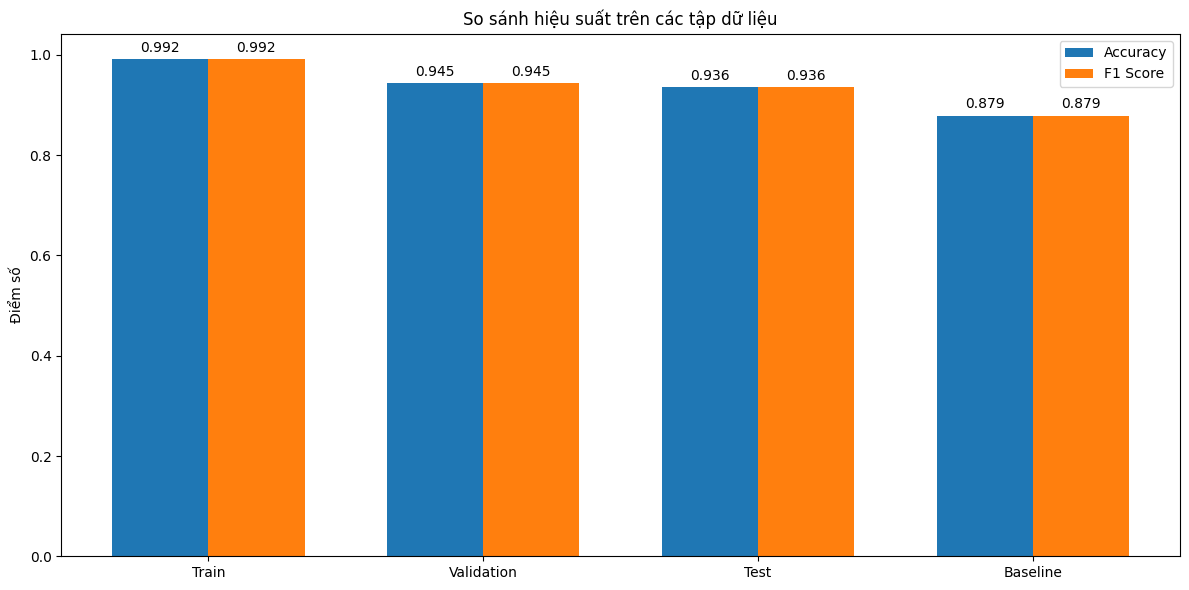

In [11]:
best_checkpoint_path = '/kaggle/working/checkpoints/phobert-sentiment-epochepoch=08-val_f1val_f1=0.9445.ckpt'  # Thay đổi đường dẫn nếu cần

eval_trainer = Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    precision='16-mixed' if torch.cuda.is_available() else '32'
)

model = SentimentClassifier.load_from_checkpoint(
    best_checkpoint_path,
    lr=5e-5,
    weight_decay=0.01,
    warmup_steps=0,
    total_steps=0
)

print("Đánh giá trên tập train:")
train_results = eval_trainer.test(model, datamodule.train_dataloader())

print("Đánh giá trên tập validation:")
val_results = eval_trainer.test(model, datamodule.val_dataloader())

print("Đánh giá trên tập test:")
test_results = eval_trainer.test(model, datamodule.test_dataloader())

results_comparison = {
    'Train': {
        'Accuracy': train_results[0]['test_acc'],
        'F1 Score': train_results[0]['test_f1']
    },
    'Validation': {
        'Accuracy': val_results[0]['test_acc'],
        'F1 Score': val_results[0]['test_f1']
    },
    'Test': {
        'Accuracy': test_results[0]['test_acc'],
        'F1 Score': test_results[0]['test_f1']
    },
    'Baseline': {
        'Accuracy': 0.879,
        'F1 Score': 0.879
    }
}

for dataset, metrics in results_comparison.items():
    print(f"{dataset}: Accuracy = {metrics['Accuracy']:.4f}, F1 Score = {metrics['F1 Score']:.4f}")

datasets = list(results_comparison.keys())
accuracy_values = [results_comparison[d]['Accuracy'] for d in datasets]
f1_values = [results_comparison[d]['F1 Score'] for d in datasets]

x = np.arange(len(datasets))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, accuracy_values, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_values, width, label='F1 Score')

ax.set_ylabel('Điểm số')
ax.set_title('So sánh hiệu suất trên các tập dữ liệu')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
fig.tight_layout()

plt.savefig('/kaggle/working/all_datasets_comparison.png')
plt.show()

In [31]:
checkpoint_path = "/kaggle/working/checkpoints/phobert-sentiment-epochepoch=08-val_f1val_f1=0.9445.ckpt"

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
state_dict = torch.load(checkpoint_path, map_location=torch.device('cuda'), weights_only=True)
if all(k.startswith('model.') for k in state_dict['state_dict'].keys()):
    state_dict['state_dict'] = {k[6:]: v for k, v in state_dict['state_dict'].items() 
                              if k.startswith('model.')}
model.load_state_dict(state_dict['state_dict'])
model.eval()

id2label = {0: "Tiêu cực", 1: "Trung lập", 2: "Tích cực"}

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    probs = probabilities[0].tolist()
    
    result = {
        "text": text,
        "sentiment": id2label[predicted_class],
        "confidence": probs[predicted_class],
        "probabilities": {id2label[i]: f"{prob:.4f}" for i, prob in enumerate(probs)}
    }
    
    return result

test_sentences = [
    "Giảng viên rất nhiệt tình và tận tâm với sinh viên.",
    "Phòng học quá chật và thiếu thiết bị.",
    "Chương trình học phù hợp và dễ tiếp thu.",
    "Thời gian học không hợp lý.",
    "Cơ sở vật chất hiện đại và đầy đủ.",
    "Bài giảng khó hiểu và không có ví dụ thực tế.",
    "Quá nhiều bài tập về nhà.",
    "Giảng viên giải thích rõ ràng và dễ hiểu.",
    "Học phí quá cao so với chất lượng.",
    "Tài liệu học tập đầy đủ và cập nhật."
]

for sentence in test_sentences:
    result = predict_sentiment(sentence)
    print(f"Câu: {result['text']}")
    print(f"Cảm xúc: {result['sentiment']} (độ tin cậy: {result['confidence']:.4f})")
    print(f"Xác suất: {result['probabilities']}")
    print("-" * 80)

def evaluate_accuracy(labeled_data):
    correct = 0
    total = len(labeled_data)
    
    for text, true_label in labeled_data:
        result = predict_sentiment(text)
        predicted_label = list(id2label.keys())[list(id2label.values()).index(result['sentiment'])]
        
        if predicted_label == true_label:
            correct += 1
            
    accuracy = correct / total
    print(f"Độ chính xác trên {total} mẫu: {accuracy:.4f} ({correct}/{total})")
    
    return accuracy

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Câu: Giảng viên rất nhiệt tình và tận tâm với sinh viên.
Cảm xúc: Trung lập (độ tin cậy: 0.9312)
Xác suất: {'Tiêu cực': '0.0003', 'Trung lập': '0.9312', 'Tích cực': '0.0685'}
--------------------------------------------------------------------------------
Câu: Phòng học quá chật và thiếu thiết bị.
Cảm xúc: Tiêu cực (độ tin cậy: 0.9997)
Xác suất: {'Tiêu cực': '0.9997', 'Trung lập': '0.0002', 'Tích cực': '0.0001'}
--------------------------------------------------------------------------------
Câu: Chương trình học phù hợp và dễ tiếp thu.
Cảm xúc: Trung lập (độ tin cậy: 0.8277)
Xác suất: {'Tiêu cực': '0.0005', 'Trung lập': '0.8277', 'Tích cực': '0.1718'}
--------------------------------------------------------------------------------
Câu: Thời gian học không hợp lý.
Cảm xúc: Tiêu cực (độ tin cậy: 0.9991)
Xác suất: {'Tiêu cực': '0.9991', 'Trung lập': '0.0008', 'Tích cực': '0.0001'}
--------------------------------------------------------------------------------
Câu: Cơ sở vật chất hiện đạ